## Read Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Set Pandas display
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

df = pd.read_csv("../parquet_files/train_data/part-00000-12b9771c-aa42-4525-a430-a8abd80280bf-c000.csv", sep=';')

## Split data into train and test

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop('fail', axis=1)

y = df.fail

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1407)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Train dataset shape:")
print(X_train.shape)

print("Test dataset shape:")
print(X_test.shape)

Train dataset shape:
(50987, 16)
Test dataset shape:
(21852, 16)


In [3]:
y_train.value_counts()

1    33691
0    17296
Name: fail, dtype: int64

## Check Missing

In [4]:
def describe_more( df ):
    feature = [] ; classes = [] ; datatype = [] ; missing = [] ; missing_perc = []
    nrow = len(df)
    for x in df:
        feature.append(x)
        classes.append(len( pd.value_counts(df[x])))
        datatype.append(df[x].dtypes)
        missing.append(sum(df[x].isnull()))
        missing_perc.append(sum(df[x].isnull()) / nrow)
    #print(var,l,t)
    levels = pd.DataFrame( { 'Feature' : feature , 'Classes' : classes , 'Datatype' : datatype, 'Missing' : missing, 'Missing Percent' : missing_perc } )
    levels.sort_values( by = 'Missing' , inplace = True , ascending= False)
    return levels

describe_more(X_train)

,Feature,Classes,Datatype,Missing,Missing Percent
4,location,2904,object,4386,0.086022
10,last_inspections,48465,object,2499,0.049012
1,resultdttm,50850,object,110,0.002157
2,issdttm,5371,object,27,0.000530
8,zip,35,float64,22,0.000431
3,state,1,object,18,0.000353
7,city,34,object,3,0.000059
0,property_id,3358,int64,0,0.000000
5,licensecat,4,object,0,0.000000
6,descript,4,object,0,0.000000


# Target Balance

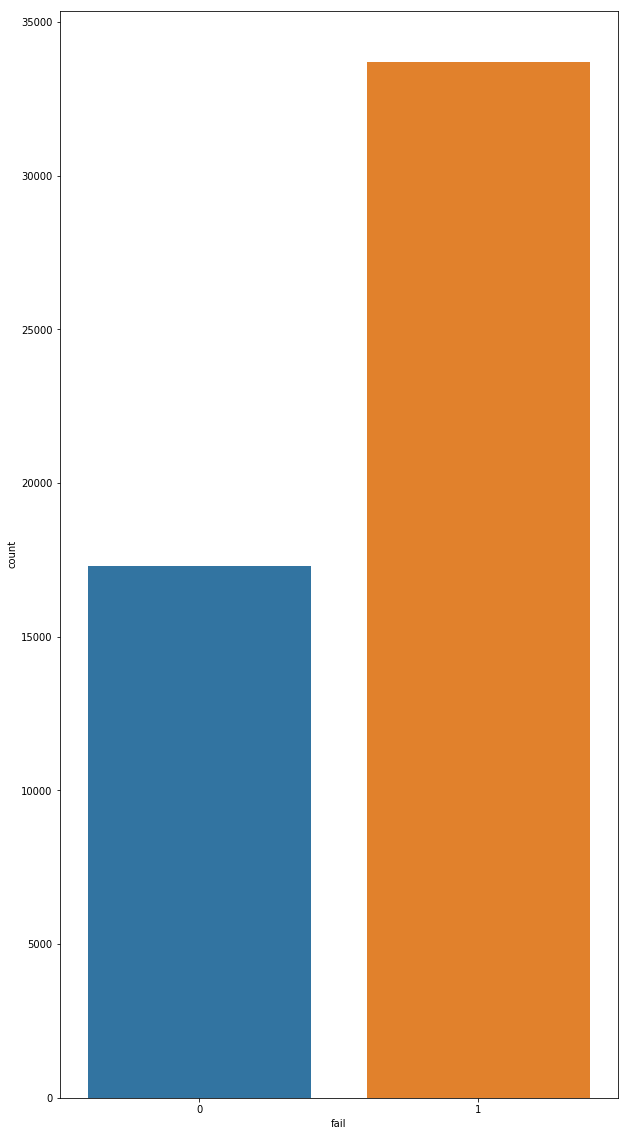

In [19]:
import seaborn as sns
sns.countplot(x='fail', data=y_train.to_frame())

# Heatmap Correlation Matrix

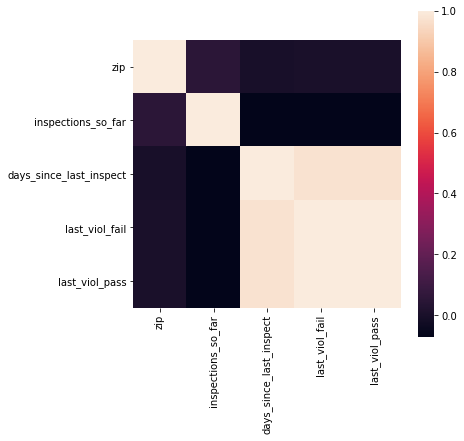

In [24]:
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax=1, square=True);


# Select Features

In [5]:
remove_cols = ['location', 'last_inspections', 'resultdttm', 'issdttm', 'property_id', 'state', 'viol_fail', 'viol_pass']

X_train = X_train.drop(remove_cols, axis=1)
X_test = X_test.drop(remove_cols, axis=1)

In [6]:
describe_more(X_train)

,Feature,Classes,Datatype,Missing,Missing Percent
3,zip,35,float64,22,0.000431
2,city,34,object,3,0.000059
0,licensecat,4,object,0,0.000000
1,descript,4,object,0,0.000000
4,inspections_so_far,1100,int64,0,0.000000
5,days_since_last_inspect,1211,int64,0,0.000000
6,last_viol_fail,50,int64,0,0.000000
7,last_viol_pass,44,int64,0,0.000000


# One Hot Encode

In [7]:
from category_encoders import OneHotEncoder

onehot = OneHotEncoder(cols=['licensecat', 'descript', 'city', 'zip'], drop_invariant=True)

X_onehot = onehot.fit_transform(X_train)
X_onehot_cols = X_onehot.columns

# Random Forest

In [8]:
from sklearn import ensemble

#params = {'max_depth': 9, 'max_features': 5, 'n_estimators': 500, 'random_state': 30}

#algorithm = ensemble.RandomForestClassifier(**params)
algorithm = ensemble.RandomForestClassifier()

# XGB Classifier

In [9]:
#from xgboost import XGBClassifier

#params = {'learning_rate': 0.01, 'max_depth ': 5, 'n_estimators': 900, 'seed': 7}
#params = {'seed': 7}

#algorithm = XGBClassifier(**params)
#algorithm = XGBClassifier()

# Pipeline

In [10]:
from sklearn.pipeline import Pipeline

steps = [('OneHotEncoder', onehot), ('Algorithm', algorithm)]

search = Pipeline(steps)

search.fit(X_train, y_train)

/home/cbologna/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('OneHotEncoder', OneHotEncoder(cols=['licensecat', 'descript', 'city', 'zip'],
       drop_invariant=True, handle_unknown='impute', impute_missing=True,
       return_df=True, use_cat_names=False, verbose=0)), ('Algorithm', RandomForestClassifier(bootstrap=True, class_weight=None, criterion=...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

# Grid Search

from sklearn.model_selection import GridSearchCV

tuned_parameters = {}
tuned_parameters['XGBClassifier__seed'] = [7]
tuned_parameters['XGBClassifier__learning_rate'] = [0.1, 0.3]
tuned_parameters['XGBClassifier__max_depth'] = [3, 6]
tuned_parameters['XGBClassifier__nthread'] = [8]

search = GridSearchCV(pipe, tuned_parameters, cv = 5, scoring='acc', n_jobs = -1, verbose = 10)

search.fit(X_train, y_train)

# Results

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [11]:
print("CV score=%0.4f" % search.score(X_test, y_test))

CV score=0.8137


In [12]:
predict = search.predict_proba(X_test)[:,1]

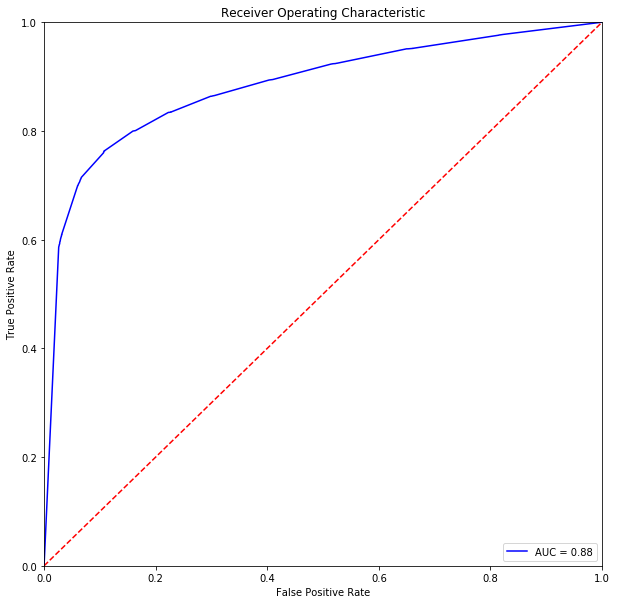

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.rcParams["figure.figsize"] = [10, 10]
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature Importance

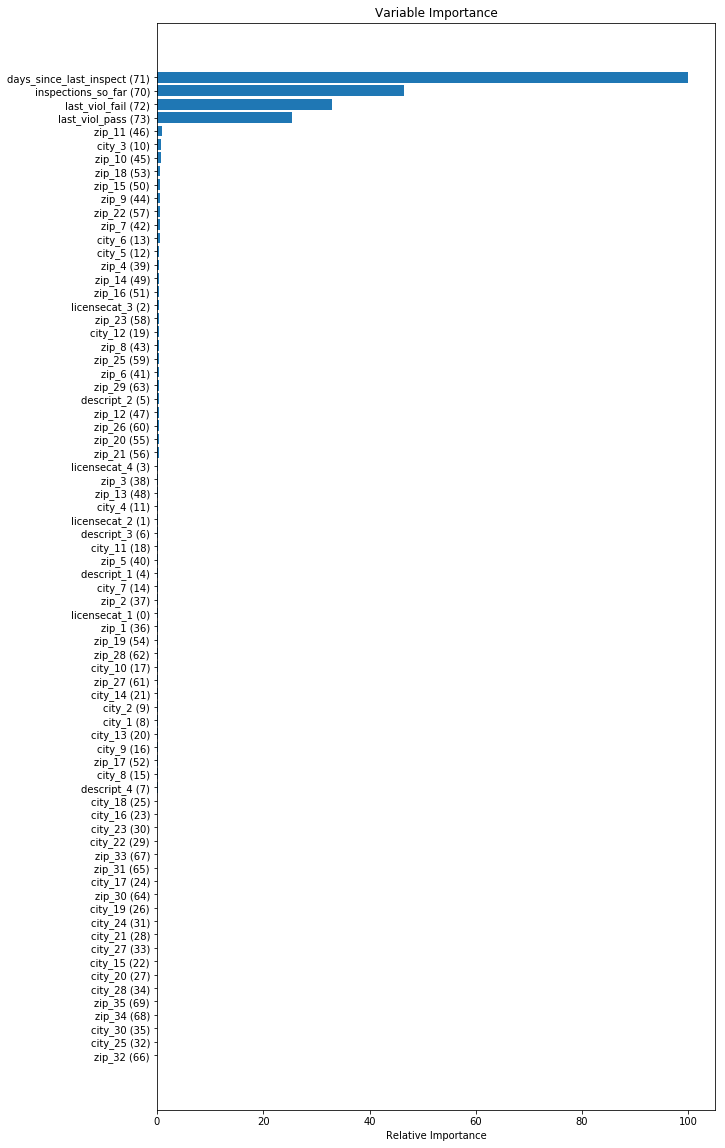

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure width and height
plt.rcParams["figure.figsize"] = [10, 20]

names = X_onehot.columns
feature_importance = steps[1][1].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos,map(lambda x: names[x] + ' (' + str(x) + ')', sorted_idx))
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()